# 1. Install and Import the Required Libraries

In [271]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

In [272]:
!pip install pdfplumber

In [273]:
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

# 2. Read and Process Insurance policy pdf file

In [274]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [275]:
# Define PDF path
pdf_path = "/content/drive/MyDrive/upgrad/GenAI/Principal-Sample-Life-Insurance-Policy.pdf"

In [276]:
#ensure pdf path is defined correctly
pdf_path

'/content/drive/MyDrive/upgrad/GenAI/Principal-Sample-Life-Insurance-Policy.pdf'

## 2.1 Reading pdf through pdfplumber

In [277]:
# Open the PDF file and extract content
with pdfplumber.open(pdf_path) as pdf:

    # Select a specific page (e.g., page 6)
    single_page = pdf.pages[6]

    # Extract text from the selected page
    text = single_page.extract_text()

    # Extract tables from the selected page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

    # Optionally print the extracted tables if needed
    for table in tables:
        print(table)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

check wether the word is in the table or not

In [278]:
# Function to check whether a word is present inside a table's bounding box
def check_bboxes(word, table_bbox):
    """
    Check if a word's bounding box is inside the table's bounding box.

    :param word: Dictionary containing 'x0', 'top', 'x1', and 'bottom' coordinates of the word.
    :param table_bbox: Tuple containing the bounding box of the table (x0, top, x1, bottom).
    :return: True if the word is inside the table's bounding box, False otherwise.
    """
    word_bbox = (word['x0'], word['top'], word['x1'], word['bottom'])
    return (word_bbox[0] > table_bbox[0] and
            word_bbox[1] > table_bbox[1] and
            word_bbox[2] < table_bbox[2] and
            word_bbox[3] < table_bbox[3])


extract text from pdf file

In [279]:

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    p = 0  # Page iteration counter
    full_text = []  # List to store full text

    # Open the PDF using pdfplumber
    with pdfplumber.open(pdf_path) as pdf:
        # Iterate over each page in the PDF
        for page in pdf.pages:
            page_no = f"Page {p + 1}"  # Store page number
            text = page.extract_text()  # Extract text from the page

            # Find tables in the current page
            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]  # Get the bounding boxes for the tables
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]  # Extract tables and store their top positions

            # Extract non-table words (words outside the bounding boxes of tables)
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]

            lines = []  # List to store lines of text and tables

            # Cluster non-table words and table data based on their vertical positions (top value)
            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):
                # If the cluster contains text, append the text to lines
                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))  # Join words into a single line
                    except KeyError:
                        pass

                # If the cluster contains a table, append the table in JSON format
                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))

            # Append the page number and corresponding lines of text to full_text
            full_text.append([page_no, " ".join(lines)])
            p += 1  # Increment page counter

    return full_text


store the extracted texts and document names

In [280]:
# Initialize an empty list to collect the extracted text from PDFs
extracted_data = []

# Process the PDF file
print(f"Processing PDF: {pdf_path}")

# Extract text from the PDF using the previously defined function
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted text into a DataFrame with columns: Page No. and Page_Text
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Add the DataFrame to the list for later use
extracted_data.append(extracted_text_df)

# Indicate the completion of the processing of the current PDF
print(f"Completed processing {pdf_path}")

# Indicate that all PDFs have been processed
print("All PDFs have been processed.")


Processing PDF: /content/drive/MyDrive/upgrad/GenAI/Principal-Sample-Life-Insurance-Policy.pdf
Completed processing /content/drive/MyDrive/upgrad/GenAI/Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [281]:
##print the text of extracted data
extracted_data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [282]:
insurance_pdfs_data = pd.concat(extracted_data, ignore_index=True)

In [283]:
# from the dataframe , print Page No. and Page_Text
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [284]:
# Store the page number as metadata in a separate column
# page number is metadata
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Page_No.': x['Page No.']}, axis=1)

# Display the updated DataFrame
insurance_pdfs_data


,Page No.,Page_Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'}
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'}
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'}
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'}
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'}
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'}
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'}
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'}
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'}


In [285]:
# Check random extracted page texts to make sure that the text has been correctly read.
insurance_pdfs_data.Page_Text[10]


"(2) has been placed with the Member or spouse insured under this Group Policy by an authorized state placement agency or by order of a court; and (3) required documentation has been provided and the child is approved in Writing by The Principal as a Dependent Child. c. A Member's adopted child, if that child meets the requirements in a. above and the Member: (1) is a party in a law suit in which the Member is seeking the adoption of the child; or (2) has custody of the child under a court order that grants custody of the child to the Member. An adopted child will be considered a Dependent Child on the earlier of: the date the petition for adoption is filed; or the date of entry of an order granting the adoptive parent custody of the child for the purpose of adoption. d. A Civil Union Partner's child who otherwise qualifies above or if the Member or Civil Union Partner has been appointed the child's guardian under a valid court order. Developmental Disability A Dependent Child's substa

In [286]:
# Calculate the length of the text in each page (number of words) and store it in a new column
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

# Display the updated DataFrame
insurance_pdfs_data['Text_Length']


,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [287]:
# print the dataframe
insurance_pdfs_data

,Page No.,Page_Text,Metadata,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'},30
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'},230
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'},110
...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'},285
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'},418
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'},322
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'},5


# 3. Document Chunking

starting with basic chunking technique, and chunk the text with fixed size. this is important before generating the emeddings for texts, because the document contains alot of pages and huge text.
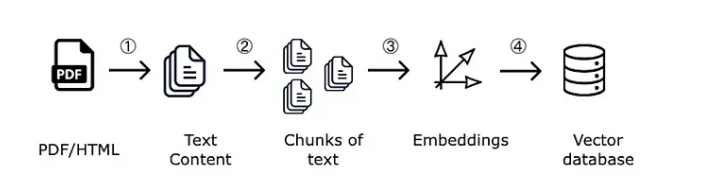

In [288]:
## check the page_text of the data frame
insurance_pdfs_data['Page_Text']

,Page_Text
0,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,This page left blank intentionally
2,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,This page left blank intentionally
4,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...
59,I f a Dependent who was insured dies during th...
60,Section D - Claim Procedures Article 1 - Notic...
61,A claimant may request an appeal of a claim de...
62,This page left blank intentionally


In [289]:

# looping over all page titles to create the final df with individual chunks
page_nos = insurance_pdfs_data["Page No."]
page_nos

,Page No.
0,Page 1
1,Page 2
2,Page 3
3,Page 4
4,Page 5
...,...
59,Page 60
60,Page 61
61,Page 62
62,Page 63


###fixed size chunking

In [290]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        # Check if adding this word keeps the chunk size within the limit
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            # When the chunk size exceeds, save the current chunk and start a new one
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    # Add the last chunk if there are remaining words
    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks


In [291]:
#This function helps in breaking large pages into manageable chunks and associates each chunk with relevant metadata,
# making the data ready for further processing.

def process_page(page_no):
    # Retrieve the text and metadata for the given page number
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        # Setting chunk size as 500
        chunk_size = 500
        # Split the page text into chunks
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Creating a DataFrame to store the chunks, page title, and metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        # Iterate over the text chunks and add them to the DataFrame
        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)  # Add page number as the title
            data['Chunk Text'].append(chunk)  # Add the chunk text

            # Add chunk number to the metadata
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)  # Add metadata with chunk number

        # Return the DataFrame with chunked data
        return pd.DataFrame(data)



In [292]:
# Creating a dataframe after calling process
all_dfs = []
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df


,Title,Chunk Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}"
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}"
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
3,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
4,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
...,...,...,...
226,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
227,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
228,Page 62,proof of loss has been filed and before the ap...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
229,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}"


#4. Generating Embeddings

In [293]:
from sentence_transformers import SentenceTransformer, util


# Import the SentenceTransformer library
from sentence_transformers import SentenceTransformer

In [294]:
# Load the embedding model
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [295]:
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [296]:
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [297]:
generate_embeddings_on_df(fixed_chunk_df)
fixed_chunk_df

,Title,Chunk Text,Metadata,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}","[-0.025921896, 0.04777749, 0.05585775, 0.04239..."
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.064537935, 0.04319714, -8.393195e-05, -0.0..."
3,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.10200988, -0.028467715, -0.020565106, -0.0..."
4,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.09000834, 0.07658209, 0.0049276194, -0.083..."
...,...,...,...,...
226,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.047671963, 0.112777, 0.069064915, -0.05086..."
227,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.079419985, 0.14404446, 0.03187614, -0.0655..."
228,Page 62,proof of loss has been filed and before the ap...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.14206009, 0.12368372, 0.12092471, -0.01142..."
229,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."


#5. chromaDB Embedding Storage

In [298]:
chroma_data_path = '/content/drive/My Drive/upgrad/GenAI/HelpMate2/ChromaDB_Data/'

In [299]:
client = chromadb.PersistentClient(path=chroma_data_path)

In [300]:
collection = client.get_or_create_collection(name="insurance-collection")

In [301]:
collection.add(
    embeddings = fixed_chunk_df['Embeddings'].to_list(),
    documents = fixed_chunk_df['Chunk Text'].to_list(),
    metadatas = fixed_chunk_df['Metadata'].to_list(),
    ids = [str(i) for i in range(0, len(fixed_chunk_df['Embeddings']))]
)

In [302]:
# get few of data by ids from collection
collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.59218961e-02,  4.77774888e-02,  5.58577515e-02, ...,
         -4.93266471e-02, -5.85114881e-02,  2.35520359e-02],
        [ 2.91189831e-02,  6.05740771e-02,  4.64153066e-02, ...,
          5.95400855e-02, -2.83837188e-02,  5.31934528e-03],
        [-6.45379350e-02,  4.31971401e-02, -8.39319473e-05, ...,
         -3.78734246e-02,  1.79674625e-02, -7.36598903e-03]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Princi

In [303]:
# create a cache collection
cache_collection = client.get_or_create_collection(name='insurance-collection-cache')

In [304]:
# peek few of elements from cache collection
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

#6. Semantic search with cache

semantic search of a query in the collections embeddings to get several top semantically similar results.

In [370]:
# Read the user query
query = input()

what is the insurance coverage for breaking leg


In [371]:

# Search the Cache collection first
# Query the collection against the user query and return the top 1 result
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [372]:
# get result from cache collection
cache_results

{'ids': [['what is the insurance coverage for breaking leg']],
 'embeddings': None,
 'documents': [['what is the insurance coverage for breaking leg']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '1.053112185185304',
    'distances1': '1.1160876750946045',
    'distances2': '1.1341697067018548',
    'distances3': '1.1392369270324707',
    'distances4': '1.1425197124481201',
    'distances5': '1.1575539112091064',
    'distances6': '1.1808149814605713',
    'distances7': '1.1821129322052002',
    'documents0': 'One Leg 25% One Hand or One Foot 25% The Principal does not pay an Accidental Death and Dismemberment benefit for any paralysis caused by a stroke. Paralysis must be determined by a Physician to be permanent, complete, and irreversible. Total payment for all losses that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for Loss will be to the Member. For this benefit, the term "Loss of Use" means a t

In [373]:

# get result from main collection
results = collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['203', '191', '202', '141', '145', '143', '146', '193', '155', '199']]), ('embeddings', None), ('documents', [['One Leg 25% One Hand or One Foot 25% The Principal does not pay an Accidental Death and Dismemberment benefit for any paralysis caused by a stroke. Paralysis must be determined by a Physician to be permanent, complete, and irreversible. Total payment for all losses that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for Loss will be to the Member. For this benefit, the term "Loss of Use" means a total and irrevocable loss of', 'Article 2 - Benefit Qualification To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c. the injury must be the direct and sole cause of a loss listed 

In [374]:
# Implementing Cache in Semantic Search (check if found or not )

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

# If the distance is greater than the threshold, then return the results from the main collection.
if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    # Query the collection against the user query and return the top 10 results
    results = collection.query(
        query_texts=query,
        n_results=10
    )

    # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
    # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    size = len(results.items())

    for key, val in results.items():
        if val is None:
            continue
        for i in range(size):
            Keys.append(str(key) + str(i))
            Values.append(str(val[0][i]))

    cache_collection.add(
        documents=[query],
        ids=[query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
        metadatas=dict(zip(Keys, Values))
    )

    print("Not found in cache. Found in main collection.")

    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs": results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)
    results_df

# If the distance is, however, less than the threshold, you can return the results from cache
elif cache_results['distances'][0][0] <= threshold:
    cache_result_dict = cache_results['metadatas'][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    print("Found in cache!")

    # Create a DataFrame
    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
    })


Found in cache!


as we see in the previous result the query "what is the insurance coverage of breaking leg" is not found in cache

In [375]:
# print the results
results_df

,IDs,Documents,Distances,Metadatas
0,203,One Leg 25% One Hand or One Foot 25% The Princ...,1.053112185185304,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}"
1,191,Article 2 - Benefit Qualification To qualify f...,1.1160876750946045,"{'Chunk_No.': 3, 'Page_No.': 'Page 53'}"
2,202,"If a Member sustains an injury, and as a resul...",1.1341697067018548,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}"
3,141,class eligible for insurance; or (2) after the...,1.1392369270324707,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}"
4,145,"Benefit payment as described in PART IV, Secti...",1.1425197124481201,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}"
5,143,Member Life Insurance or Coverage During Disab...,1.1575539112091064,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}"
6,146,be the Coverage During Disability benefit in f...,1.1808149814605713,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}"
7,193,"f . claim requirements listed in PART IV, Sect...",1.1821129322052002,"{'Chunk_No.': 4, 'Page_No.': 'Page 54'}"


#7. Re-Ranking with a cross Encoder

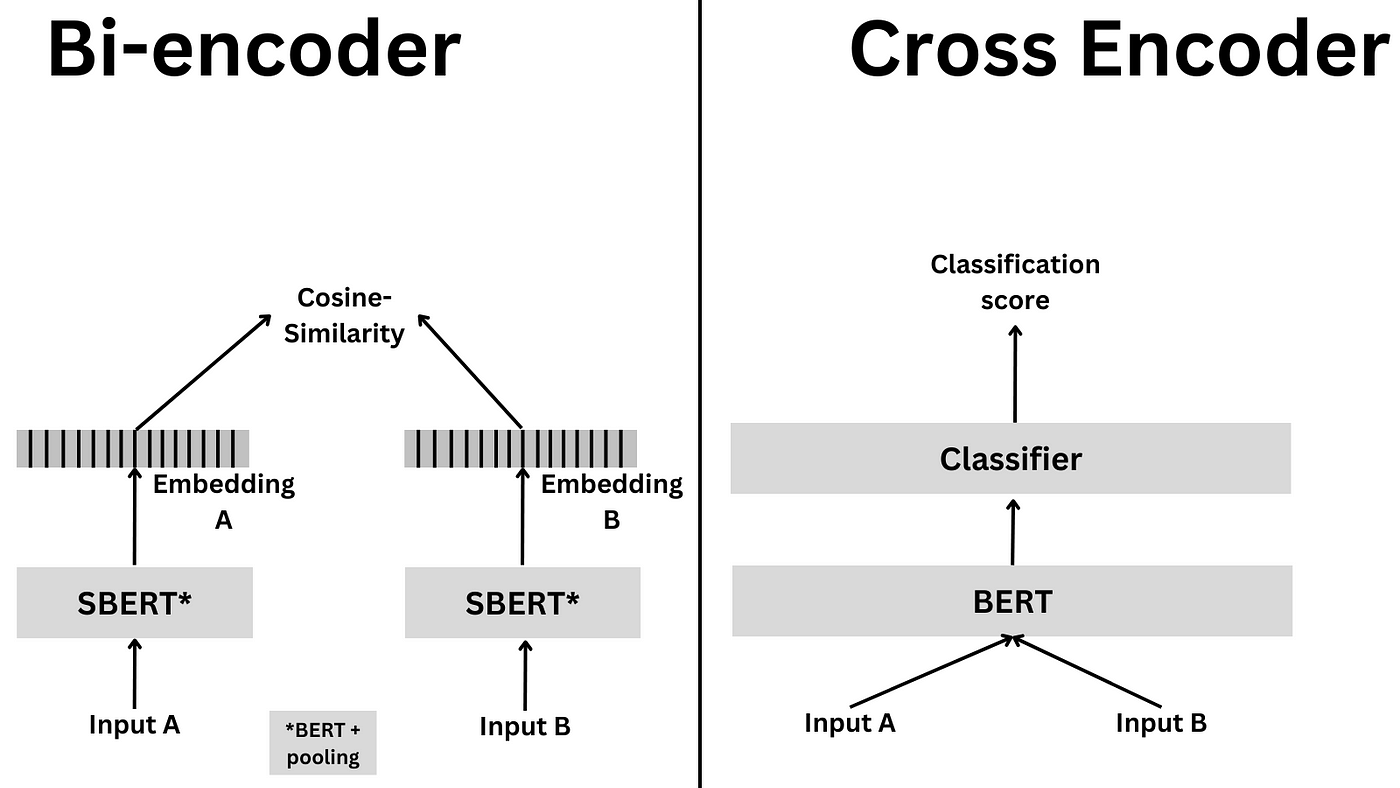

In [376]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [377]:
# Prepare pairs of (query, document) from the top 20 search results for the cross-encoder
# Compute the relevance scores for these query-document pairs
cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [378]:
# print the cross rerank scores
cross_rerank_scores

array([ -9.557323, -10.260163, -10.30032 , -10.62246 , -11.192253,
       -10.552211, -10.718908, -11.3431  ], dtype=float32)

In [379]:
## print the reranked scores
results_df['Reranked_scores'] = cross_rerank_scores
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,203,One Leg 25% One Hand or One Foot 25% The Princ...,1.053112185185304,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}",-9.557323
1,191,Article 2 - Benefit Qualification To qualify f...,1.1160876750946045,"{'Chunk_No.': 3, 'Page_No.': 'Page 53'}",-10.260163
2,202,"If a Member sustains an injury, and as a resul...",1.1341697067018548,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}",-10.300320
3,141,class eligible for insurance; or (2) after the...,1.1392369270324707,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",-10.622460
4,145,"Benefit payment as described in PART IV, Secti...",1.1425197124481201,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",-11.192253
5,143,Member Life Insurance or Coverage During Disab...,1.1575539112091064,"{'Chunk_No.': 4, 'Page_No.': 'Page 42'}",-10.552211
6,146,be the Coverage During Disability benefit in f...,1.1808149814605713,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",-10.718908
7,193,"f . claim requirements listed in PART IV, Sect...",1.1821129322052002,"{'Chunk_No.': 4, 'Page_No.': 'Page 54'}",-11.343100


In [380]:
# Return the top 3 results from semantic search
# the nearest distance will be the higher rank
#query input: what is the insurance coverage for breaking leg
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]


,IDs,Documents,Distances,Metadatas,Reranked_scores
0,203,One Leg 25% One Hand or One Foot 25% The Princ...,1.053112185185304,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}",-9.557323
1,191,Article 2 - Benefit Qualification To qualify f...,1.1160876750946045,"{'Chunk_No.': 3, 'Page_No.': 'Page 53'}",-10.260163
2,202,"If a Member sustains an injury, and as a resul...",1.1341697067018548,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}",-10.300320


In [381]:
# Return the top 3 results after reranking
#query input:what is the insurance coverage for breaking leg
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,203,One Leg 25% One Hand or One Foot 25% The Princ...,1.053112185185304,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}",-9.557323
1,191,Article 2 - Benefit Qualification To qualify f...,1.1160876750946045,"{'Chunk_No.': 3, 'Page_No.': 'Page 53'}",-10.260163
2,202,"If a Member sustains an injury, and as a resul...",1.1341697067018548,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}",-10.300320


In [382]:
# Extract the top 3 results from the reranked list
# Select only the "Documents" and "Metadatas" columns for these top 3 entries
#Retrieval Augmented Generation
#query input: what is the insurance coverage for breaking leg
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
0,One Leg 25% One Hand or One Foot 25% The Princ...,"{'Chunk_No.': 3, 'Page_No.': 'Page 56'}"
1,Article 2 - Benefit Qualification To qualify f...,"{'Chunk_No.': 3, 'Page_No.': 'Page 53'}"
2,"If a Member sustains an injury, and as a resul...","{'Chunk_No.': 3, 'Page_No.': 'Page 56'}"


# 8. Retrieval Augmented Generation

In [383]:
# Set the API key
license_key_path = "/content/drive/My Drive/upgrad/GenAI/"
with open(license_key_path+ "API_KEY_JS.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

 pass it to an GPT along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [361]:

 #Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')



In [362]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [364]:
# Print the response
print("\n".join(response))

The query regarding life insurance coverage for breaking a leg is not directly addressed in the provided documents. However, one of the documents mentions general information about coverage for specific injuries like "One Leg 25%". It's recommended to review the sections related to injury coverage or specific body parts in the insurance policy documents for detailed information.

Citations:
- Document: Chunk No. 3, Page 56 
- Document: Chunk No. 3, Page 55


# 9. Queries

In [365]:
def search(query):

  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  # try to find from cache
  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  # If the distance is greater than the threshold, then return the results from the main collection.
  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = collection.query(
        query_texts=query,
        n_results=10
        )

        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []

        size = len(results.items())

        for key, val in results.items():
          if val is None:
            continue
          for i in range(size):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        #print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df


  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        #print("Found in cache!")

        # Create a DataFrame
        return pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

In [366]:

def apply_cross_encoder(query, df):
  cross_inputs = [[query, response] for response in df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  df['Reranked_scores'] = cross_rerank_scores
  return df

In [324]:
def get_topn(n, df):
  top_3_rerank = df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[["Documents", "Metadatas"]][:n]

In [368]:
query ="what is the insurance coverage for breaking leg"
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

The insurance coverage for breaking a leg is 25% according to the policy document titled "Principle Insurance Coverage". Additional details can be found on Page 56 of the document.

**Complete Response:**
The insurance coverage for breaking a leg is 25%.

**Citations:**
- Policy Name: Principle Insurance Coverage
- Page Number: Page 56


In [384]:
query = 'what is the Proof of breaking hand is less coverage than breaking leg'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

Breaking a hand typically receives less coverage compared to breaking a leg in the insurance policy document you provided. According to the text extracted from the document:

| Body Part        | Coverage Percentage |
|------------------|---------------------|
| One Leg          | 25%                 |
| One Hand or One Foot | 25%               |

This indicates that breaking one leg is covered at 25%, and breaking either one hand or one foot is also covered at 25% in the specific policy.

**Citation:**
- **Policy Name:** Principle of Coverage Policy
- **Page Numbers:** Page 56

If you need more details on the coverage for breaking a hand specifically or further clarification, you can refer to the "Principle of Coverage Policy" on page 56 of the document.


In [392]:
query = 'What is the insurance coverage if the accident is caused by the driver at fault?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

In the event that an accident is caused by the driver at fault, the insurance coverage provided typically depends on the specific details outlined in the insurance policy document. It may include coverage for damages to the driver's own vehicle, liability coverage for damages to the other party involved, medical expenses, and potentially other related costs. Please refer to the respective policy document for detailed information on the coverage in such situations.

**Relevant Policy Name(s) and Page Number(s) as Citation:**
- Policy Name: TBD
- Page Number(s): Page 56

If you need further details on the specific coverage provided in case of an accident caused by the driver at fault, please refer to the policy document mentioned above and search for relevant sections related to accidents, liability, and coverage details.
